In [33]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [34]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Splitting data for training/testing

In [35]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In [36]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

In [37]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

There existed a systematic bias in the tax system and a highly regressive taxation system was put in place that targeted black/latino homeowners in Cook County. The plan was poorly designed and overvalued inexpensive properties while undervaluing expensive properties. There was also an issue of corruption that contributed to the implemented model. This caused lower-class individuals to struggle further as they had to pay more taxes for something not worth that much.

With high segregation in certain areas, the concept of redlining along with the tax system places a highly disproportionate tax burden on non-white property owners as these areas are labeled as riskier. This makes it harder for owners in these areas to take out loans or get support from financial firms. Over time, race became a factor in valuing property as certain areas have common demographic patterns. 

---
Function to split data for training the model and testing with cross-validation.

In [38]:
np.random.seed(1337)


def train_val_split(data):
    """ 
    Takes in a dataframe and randomly splits it into two smaller dataframes 
    for training and validation with 80% and 20% of the data respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split = int(data_len * 0.8)
    train_indices = shuffled_indices[0:split]
    validation_indices = shuffled_indices[split:]
    train = data.iloc[train_indices, :]
    validation = data.iloc[validation_indices, :]
   
    return train, validation
train, validation = train_val_split(training_val_data)
train.shape

(163833, 62)

In [39]:
# The data loaded
full_data = pd.read_csv("cook_county_train.csv")
full_data.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


## Metric for evaluating Model

Utilizing RMSE as the metric to understand our models accuracy

In [40]:
def rmse(predicted, actual):
    """
    Calculating RMSE from actual and predicted values
    Used as metric for model accuracy.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [41]:
# %reset -f
# del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m2

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

# Potential Features for use

Potential Variables to Include: 'Land Square Feet', 'Garage 1 Area'

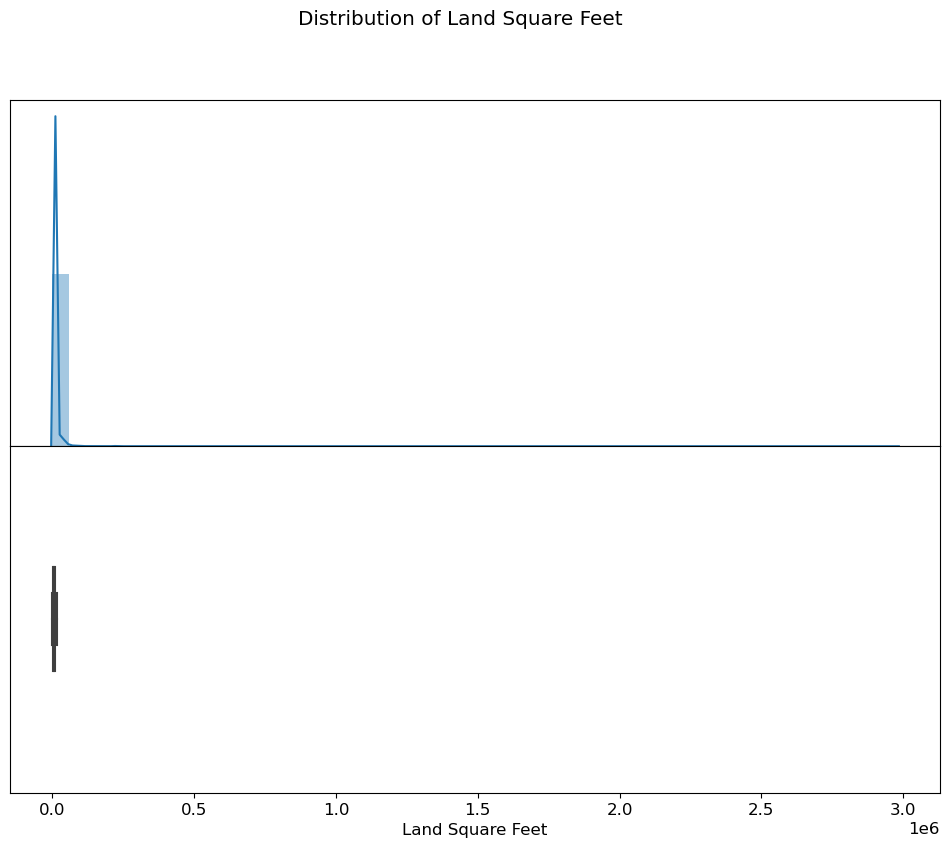

In [42]:
# EDA code below
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

plot_distribution(full_data, label = 'Land Square Feet')

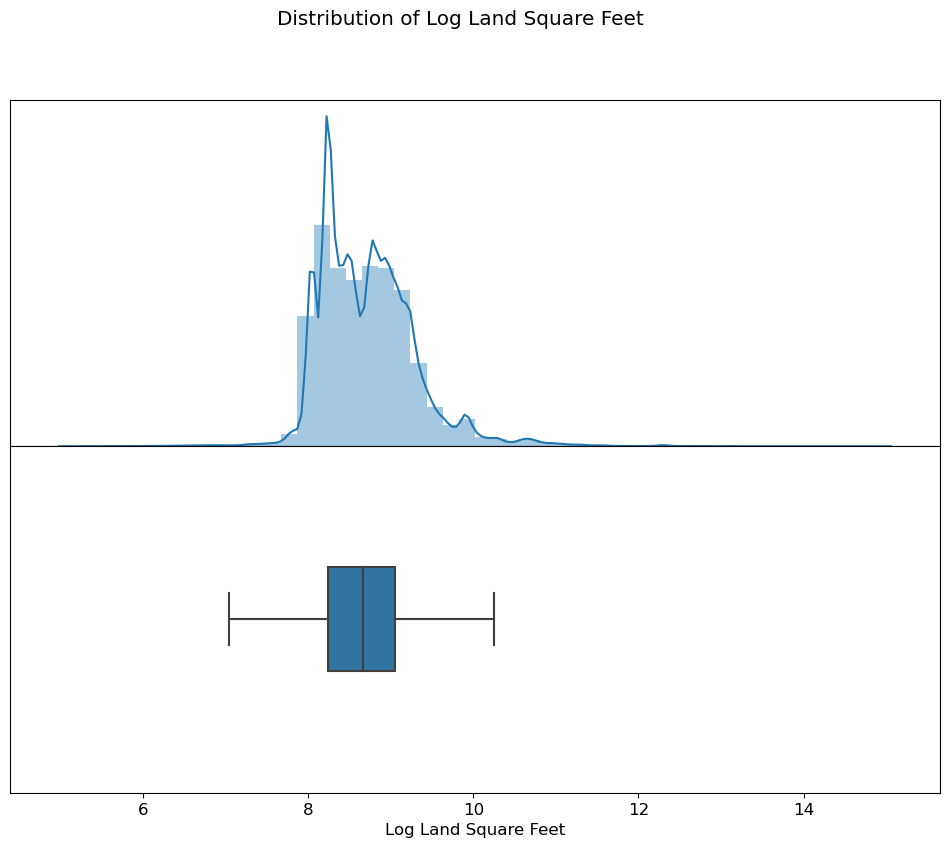

In [43]:
# EDA code below
full_data1 = full_data.copy()
full_data1['Log Land Square Feet'] = np.log(full_data1['Land Square Feet'])
full_data1['Log Sale Price'] = np.log(full_data1['Sale Price'])
plot_distribution(full_data1, label = 'Log Land Square Feet')

<Axes: xlabel='Log Lot Size', ylabel='Log Sale Price'>

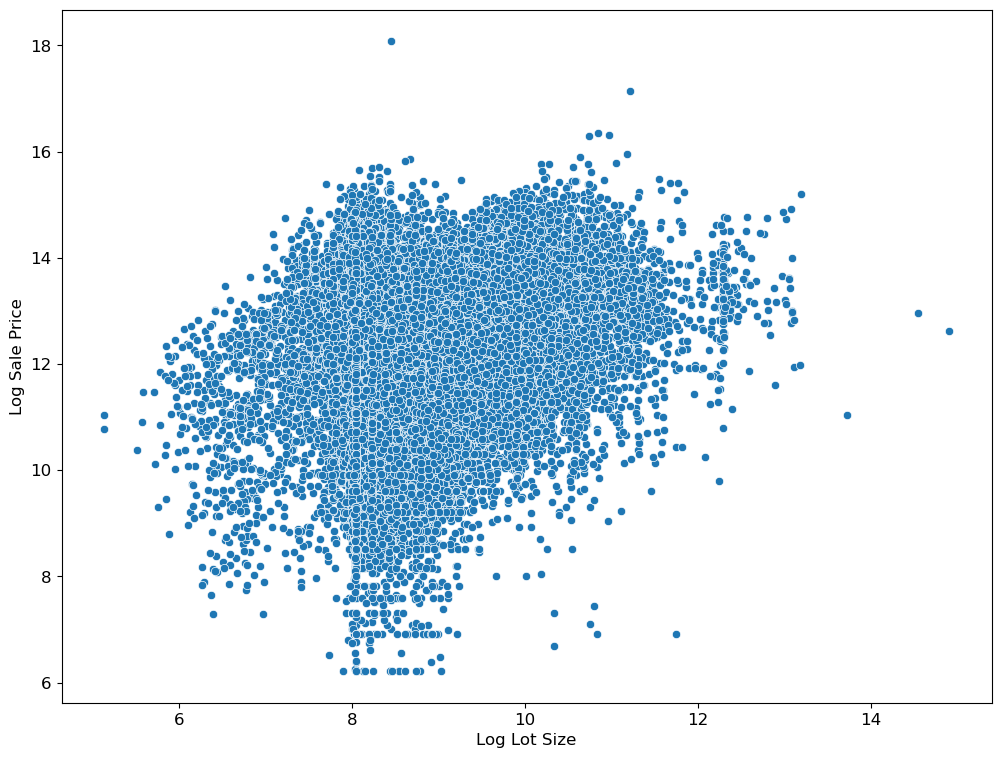

In [44]:
# EDA code below
full_data1['Log Lot Size'] = np.log(full_data1['Lot Size'])
full_data1 = remove_outliers(full_data1, 'Sale Price', lower = 499)
sns.scatterplot(data = full_data1, x = 'Log Lot Size', y= 'Log Sale Price')

<Axes: xlabel='Log Land Square Feet', ylabel='Log Sale Price'>

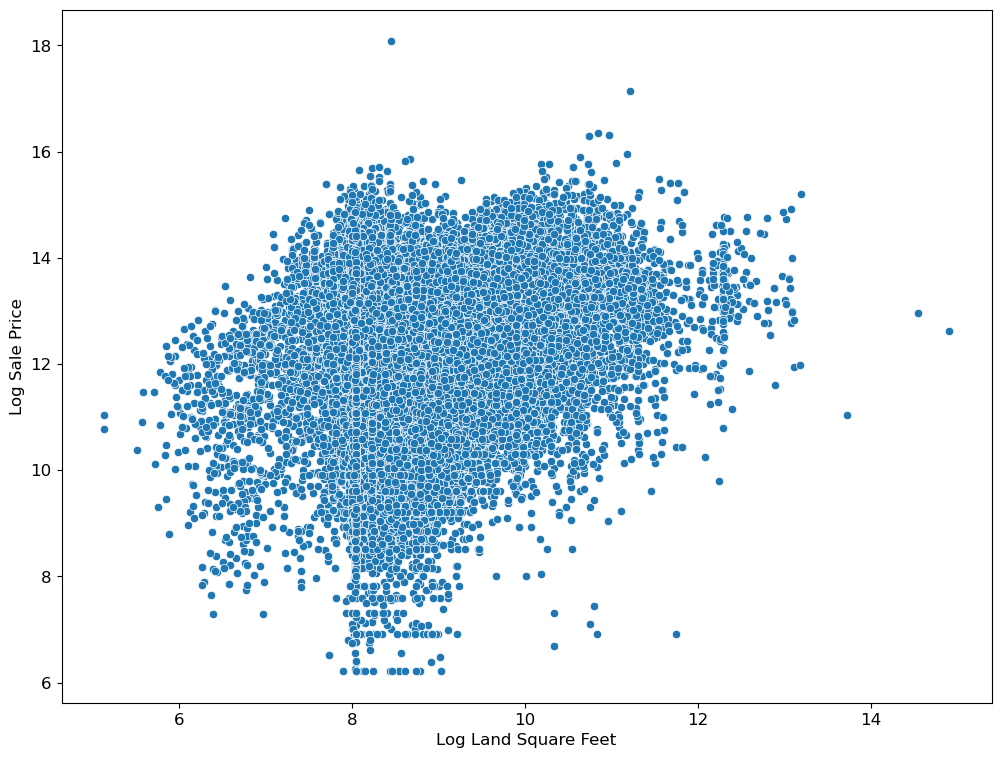

In [45]:
# EDA code below
full_data1['Sqrt Land Square Feet'] = np.sqrt(full_data1['Land Square Feet'])
sns.scatterplot(data = full_data1, x = 'Log Land Square Feet', y = 'Log Sale Price')

In [46]:
# Additional helper functions
def ohe_construction_quality(data):
    """
    One-hot-encodes construction quality.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Construction Quality']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Construction Quality']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

def ohe_apartments(data):
    """
    One-hot-encodes construction quality.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Apartments']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Apartments']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

def ohe_prop_class(data):
    """
    One-hot-encodes construction quality.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Property Class']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Property Class']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

---

## Pipeline function

In [47]:
def process_data_final(data, is_test_set=False):
    if not is_test_set:
        # processing for the training set (i.e. not the test set)
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data = remove_outliers(data, 'Sale Price', lower = 499)
    else:
        ...
    # processing for both the train and test set
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    data['Log Land Square Feet'] = np.log(data['Land Square Feet'])
    data['Log Lot Size'] = np.log(data['Lot Size'])
    data = add_total_bedrooms(data)
    data = ohe_roof_material(data)
    data = ohe_construction_quality(data)
    data = ohe_prop_class(data)
    cols = ['Bedrooms', 'Log Building Square Feet', 'Log Land Square Feet', 'Log Lot Size', 'Roof Material_1.0', 'Roof Material_2.0', 'Roof Material_3.0', 'Roof Material_4.0',	'Roof Material_5.0', 'Roof Material_6.0', 'Construction Quality_1.0', 'Construction Quality_2.0', 'Construction Quality_3.0', 'Property Class_202', 'Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278']
    
    # Return predictors and response variable separately
    if is_test_set:
        # Predictors
        X = data.loc[:, cols]
        return X
    else:
        # Predictors
        X = data.loc[:, cols]
        # Response variable
        y = data['Log Sale Price']
        
        return X, y

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 304698.1245177897


In [68]:
from datetime import datetime

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )


In [76]:
test_set = pd.read_csv('cook_county_contest_test.csv')
#test_set['Log Sale Price'] = np.log(test_set['Sale Price'])
test_set.columns

Index(['Unnamed: 0', 'PIN', 'Property Class', 'Neighborhood Code',
       'Land Square Feet', 'Town Code', 'Apartments', 'Wall Material',
       'Roof Material', 'Basement', 'Basement Finish', 'Central Heating',
       'Other Heating', 'Central Air', 'Fireplaces', 'Attic Type',
       'Attic Finish', 'Design Plan', 'Cathedral Ceiling',
       'Construction Quality', 'Site Desirability', 'Garage 1 Size',
       'Garage 1 Material', 'Garage 1 Attachment', 'Garage 1 Area',
       'Garage 2 Size', 'Garage 2 Material', 'Garage 2 Attachment',
       'Garage 2 Area', 'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Longitude',
       'Latitude', 'Census Tract', 'Multi Property Indicator',
       'Modeling Group', 'Age', 'Use', 'O'Hare Noise', 'Floodplain',
       'Road Proximity', 'Sale Year', 'Sale Quarter', 'Sale Half-Year',
       'Sale Quarter of Year'

In [70]:
Y_test_pred

array([13.86523438, 12.02294922, 12.07568359, ..., 12.10693359,
       13.29882812, 13.72509766])

In [178]:
# Scratch space to check if your prediction is reasonable. See 4f for hints. 
# We will not reset submission count for mis-submission issues.
submission_df["Value"].describe()

count    55311.000000
mean        12.191557
std          0.601356
min         10.403809
25%         11.763184
50%         12.044434
75%         12.511719
max         15.079590
Name: Value, dtype: float64